## Importing the Libraries

In [ ]:
import re                        
import pickle
import numpy as np
import pandas as pd
from statistics import mode
from bs4 import BeautifulSoup  

import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from pprint import pprint

import tensorflow as tf
from matplotlib import pyplot
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import backend as K 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from sklearn.model_selection import train_test_split

import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_csv('/content/gdrive/MyDrive/Reviews.csv',nrows=100000)

# data = pd.read_csv("Reviews.csv",nrows=100000)
data.info()

Mounted at /content/gdrive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      100000 non-null  int64 
 1   ProductId               100000 non-null  object
 2   UserId                  100000 non-null  object
 3   ProfileName             99996 non-null   object
 4   HelpfulnessNumerator    100000 non-null  int64 
 5   HelpfulnessDenominator  100000 non-null  int64 
 6   Score                   100000 non-null  int64 
 7   Time                    100000 non-null  int64 
 8   Summary                 99998 non-null   object
 9   Text                    100000 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.6+ MB


### Results Before Preprocessing

In [ ]:
print("Text:   ")
data['Text'][:1][0]

Text:   


'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [ ]:
print("Summary:  ")
data['Summary'][:1][0]

Summary:  


'Good Quality Dog Food'

## Preprocessing the Data

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

### Cleaning the Data from the Dataset

In [ ]:
data.drop_duplicates(subset = ['Text'], inplace=True)
data.dropna(axis = 0, inplace = True)

stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping 
                          else t for t in newString.split(" ")])    

    if(num == 0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens = newString.split()

    long_words = []
    for i in tokens:
        if len(i) > 3:                                           
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0)) 

cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

data['cleaned_text'] = cleaned_text
data['cleaned_summary'] = cleaned_summary

data.replace('', np.nan, inplace = True)
data.dropna(axis = 0, inplace = True)

max_text_len = 30
max_summary_len = 8

cleaned_text = np.array(data['cleaned_text'])
cleaned_summary = np.array(data['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split()) <= max_summary_len and 
       len(cleaned_text[i].split()) <= max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
data = pd.DataFrame({'Text':short_text,'Summary':short_summary})

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


#### Results of 1st Preprocessing

In [ ]:
print("Text :")
data['Text'][:1][0]

Text :


'bought several vitality canned food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better'

In [ ]:
print("Summary")
data['Summary'][:1][0]

Summary


'good quality food'

In [ ]:
print("Data Observations")
print("Text:    ",len(data['Text']))
print("Summary: ",len(data['Summary']))

Data Observations
Text:     52559
Summary:  52559


### Finalizing the Cleaned Data

In [ ]:
data.drop_duplicates(subset = ['Text'], inplace = True)
data.dropna(axis = 0, inplace = True)
input_data = data.loc[:,'Text']
target_data = data.loc[:,'Summary']
target_data.replace('', np.nan, inplace = True)

input_texts = []
target_texts = []
input_words = []
target_words = []

stop_words = set(stopwords.words('english'))
stemm = LancasterStemmer()

# This function is to clean the User's Input text
def clean(texts,src):
  words = word_tokenize(texts.lower())
  words = list(filter(lambda w:(w.isalpha() and len(w) >= 3),words))
  
  # Stem the words to their root word and filter stop words
  if src == "inputs":
    words = [stemm.stem(w) for w in words if w not in stop_words]
  else:
    words = [w for w in words if w not in stop_words]
  return words

for in_txt, tr_txt in zip(input_data, target_data):
  in_words = clean(in_txt,"inputs")
  input_texts += [' '.join(in_words)]
  input_words += in_words

  tr_words = clean("sos "+ tr_txt +" eos", "target")
  target_texts += [' '.join(tr_words)]
  target_words += tr_words

# Store only unique words
input_words = sorted(list(set(input_words)))
target_words = sorted(list(set(target_words)))
num_in_words = len(input_words) 
num_tr_words = len(target_words)

# Counting the Input and target texts which appears most often  
max_in_len = mode([len(i) for i in input_texts])
max_tr_len = mode([len(i) for i in target_texts])

max_in_len = 30
max_tr_len = 8
print("number of input words : ",num_in_words)
print("number of target words : ",num_tr_words)

number of input words :  16597
number of target words :  9714


#### Results of 2nd Preprocessing

In [ ]:
print("Text :")
input_texts[:1][0]

Text :


'bought sev vit can food produc found good qual produc look lik stew process meat smel bet labrad finicky apprecy produc bet'

In [ ]:
print("Summary :")
target_texts[:1][0]

Summary :


'sos good quality food eos'

In [ ]:
print("Data Observations")
print("Text:    ",len(input_texts))
print("Summary: ",len(target_texts))

Data Observations
Text:     52532
Summary:  52532


## Data Segregation

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(input_texts,
                                                    target_texts,
                                                    test_size = 0.1,
                                                    random_state = 1)

# Tokenizing the training dataset
in_tokenizer = Tokenizer()
in_tokenizer.fit_on_texts(x_train)
tr_tokenizer = Tokenizer()
tr_tokenizer.fit_on_texts(y_train)

# Converting text into sequence of integers
x_train = in_tokenizer.texts_to_sequences(x_train) 
y_train = tr_tokenizer.texts_to_sequences(y_train) 

# Padding the array with 0's
en_in_data = pad_sequences(x_train,  maxlen = max_in_len, padding='post') 
dec_data = pad_sequences(y_train,  maxlen = max_tr_len, padding='post')

# Decoder input will excludes the last word i.e. 'eos'
dec_in_data = dec_data[:,:-1]

# Decoder target excludes the first word i.e 'sos'
dec_tr_data = dec_data.reshape(len(dec_data),max_tr_len,1)[:,1:]

## Building a Model

In [ ]:
K.clear_session() 
latent_dim = 300
emb_dim = 100
en_inputs = Input(shape = (max_in_len,)) 
en_embedding = Embedding(num_in_words+1,
                         emb_dim,
                         trainable = True)(en_inputs) 

# LSTM 1
en_lstm1 = LSTM(latent_dim, 
                return_state = True, 
                return_sequences = True, 
                dropout = 0.4, 
                recurrent_dropout = 0.4) 
en_outputs1, state_h1, state_c1 = en_lstm1(en_embedding) 

# LSTM2
en_lstm2 = LSTM(latent_dim,
                return_state = True,
                return_sequences = True, 
                dropout = 0.4, 
                recurrent_dropout = 0.4)
en_outputs2, state_h2, state_c2 = en_lstm2(en_outputs1) 

# LSTM3
en_lstm3 = LSTM(latent_dim, 
                return_state = True, 
                return_sequences = True, 
                dropout = 0.4, 
                recurrent_dropout = 0.4)
en_outputs3 , state_h3, state_c3 = en_lstm3(en_outputs2)
en_states = [state_h3, state_c3]

# Decoder 
dec_inputs = Input(shape = (None, )) 
dec_emb_layer = Embedding(num_tr_words+1, 
                          emb_dim,
                          trainable = True) 
dec_embedding = dec_emb_layer(dec_inputs) 

# Initialize decoder's LSTM
dec_lstm = LSTM(latent_dim, 
                return_sequences = True, 
                return_state = True,
                dropout = 0.4, 
                recurrent_dropout = 0.4)
dec_outputs, *_ = dec_lstm(dec_embedding, 
                           initial_state = en_states) 

# Attention layer
attention = Attention()
attn_out = attention([dec_outputs, en_outputs3])

# Concatenate the attention output with the decoder ouputs
merge = Concatenate(axis = -1, name = 'concat_layer1')([dec_outputs, 
                                                        attn_out])

# Dense layer
dec_dense = Dense(num_tr_words+1, activation = 'softmax') 
dec_outputs = dec_dense(merge) 

# Model Summary
model = Model([en_inputs, dec_inputs], dec_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 100)      1659800     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 30, 300),    481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

### Training the Model

In [ ]:
plot_model(model, 
           to_file ='model_plot.png', 
           show_shapes = True, 
           show_layer_names = True)

model.compile(optimizer = "rmsprop", 
              loss = "sparse_categorical_crossentropy", 
              metrics = ["accuracy"] ) 

es = EarlyStopping(monitor = 'val_loss', 
                   mode ='min', 
                   verbose = 1, 
                   patience = 2)

graph = model.fit([en_in_data, dec_in_data],
                    dec_tr_data, 
                    batch_size = 128, 
                    epochs = 50,
                    callbacks = [es], 
                    validation_split = 0.1)

model.save("Model")

Epoch 1/50
333/333 [==============================] - 186s 521ms/step - loss: 2.5724 - accuracy: 0.6623 - val_loss: 2.3703 - val_accuracy: 0.6864
Epoch 2/50
333/333 [==============================] - 158s 475ms/step - loss: 2.3216 - accuracy: 0.6863 - val_loss: 2.3060 - val_accuracy: 0.6876
Epoch 3/50
333/333 [==============================] - 158s 475ms/step - loss: 2.2468 - accuracy: 0.6884 - val_loss: 2.2464 - val_accuracy: 0.6888
Epoch 4/50
333/333 [==============================] - 156s 469ms/step - loss: 2.1968 - accuracy: 0.6894 - val_loss: 2.2260 - val_accuracy: 0.6897
Epoch 5/50
333/333 [==============================] - 157s 472ms/step - loss: 2.1604 - accuracy: 0.6913 - val_loss: 2.2043 - val_accuracy: 0.6912
Epoch 6/50
333/333 [==============================] - 157s 472ms/step - loss: 2.1251 - accuracy: 0.6933 - val_loss: 2.1923 - val_accuracy: 0.6923
Epoch 7/50
333/333 [==============================] - 154s 464ms/step - loss: 2.0904 - accuracy: 0.6951 - val_loss: 2.1604 -

### Model Performance

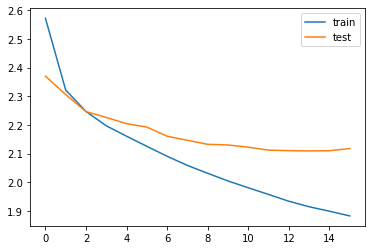

In [ ]:
from matplotlib import pyplot
pyplot.plot(graph.history['loss'], label='train')
pyplot.plot(graph.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Model Inference

In [ ]:
model = models.load_model("Model")

# Encoder Inference
latent_dim = 300

## Encoder Model
en_outputs, state_h_enc, state_c_enc = model.layers[6].output
en_states = [state_h_enc, state_c_enc]
en_model = Model(model.input[0], [en_outputs] + en_states)

# Decoder Inference
dec_state_input_h = Input(shape = (latent_dim, ))
dec_state_input_c = Input(shape = (latent_dim, ))
dec_hidden_state_input = Input(shape = (max_in_len, latent_dim))

dec_inputs = model.input[1]
dec_emb_layer = model.layers[5]
dec_lstm = model.layers[7]
dec_embedding = dec_emb_layer(dec_inputs)

# Initialize Decoder LSTM
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_embedding, 
                                            initial_state = [dec_state_input_h,
                                                             dec_state_input_c])

# Attention layer
attention = model.layers[8]
attn_out2 = attention([dec_outputs2, dec_hidden_state_input])

# Concatenating Layer
merge2 = Concatenate(axis = -1)([dec_outputs2, attn_out2])

# Dense layer
dec_dense = model.layers[10]
dec_outputs2 = dec_dense(merge2)

## Decoder Model
dec_model = Model(
[dec_inputs] + [dec_hidden_state_input, dec_state_input_h, dec_state_input_c],
[dec_outputs2] + [state_h2, state_c2])

## Decoding Sequence

In [ ]:
# Reverting Back to words from tokenizer
reverse_target_word_index = tr_tokenizer.index_word
reverse_source_word_index = in_tokenizer.index_word
target_word_index = tr_tokenizer.word_index
reverse_target_word_index[0] = ' '

def decode_sequence(input):
    encoder_out, encoder_h, encoder_c = en_model.predict(input)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['sos']
    stop_condition = False
    decoded_sentence = ""
    
    while not stop_condition: 
        output_words, decoder_h, decoder_c = dec_model.predict([target_seq] + [encoder_out,
                                                                                   encoder_h,  
                                                                                   encoder_c])
        word_index = np.argmax(output_words[0, -1, :])
        text_word = reverse_target_word_index[word_index]
        decoded_sentence += text_word +" "

        if text_word == "eos" or len(decoded_sentence) > max_tr_len:
          stop_condition = True
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = word_index
        encoder_h, encoder_c = decoder_h, decoder_c

    return decoded_sentence

## Results

In [ ]:
User_Inputs =["the product was best product I would recommend it at all. I would even give ten stars.",
     "it is horrible , not at all worth it. The product was defected and not working.",
     "I received defected product.Return is also not possible. \n The product shown in the image is very different from the one that I received",
     "The product is complete worthless and I hate it. Definite two stars not more than that",
     "I was skeptical about the product, it exceeded my expectation",
     "Worst product ever made",
     "The seller is fake , I recived the product late and it was also damaged. I am heavily dissapointed.",
     "One word worth it. Every penny is worth it for this product",
     "The product initally looked good but half the way the display went off. Very disappointing and misleading discription ",
     "The seller refused to refund the product even though it is defected."     ]

for i in User_Inputs:
  inp_review = clean(i,"inputs")
  inp_review = ' '.join(inp_review)
  inp_x = in_tokenizer.texts_to_sequences([inp_review]) 
  inp_x = pad_sequences(inp_x,  maxlen = max_in_len, padding = 'post')

  summary = decode_sequence(inp_x.reshape(1, max_in_len))
  if 'eos' in summary :
    summary = summary.replace('eos','')
  print("Actual Text:     ",i)
  print("Predicted summary:",summary);
  print("\n")

Actual Text:      the product was best product I would recommend it at all. I would even give ten stars.
Predicted summary: great product 


Actual Text:      it is horrible , not at all worth it. The product was defected and not working.
Predicted summary: horrible 


Actual Text:      I received defected product.Return is also not possible. 
 The product shown in the image is very different from the one that I received
Predicted summary: damaged cans 


Actual Text:      The product is complete worthless and I hate it. Definite two stars not more than that
Predicted summary: good  


Actual Text:      I was skeptical about the product, it exceeded my expectation
Predicted summary: good  


Actual Text:      Worst product ever made
Predicted summary: horrible 


Actual Text:      The seller is fake , I recived the product late and it was also damaged. I am heavily dissapointed.
Predicted summary: beware  


Actual Text:      One word worth it. Every penny is worth it for this product
